# Simple example for how to load and plot ice data

This script shows how to load and plot sea ice concentration from CICE output, while also indicating how to get around some of the pitfalls and foibles in CICE temporal and spatial gridding.

Firstly, load bare minimum modules:

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
from dask.distributed import Client
from datetime import timedelta

If we want, we can start a client - not strictly necessary for this small case but could help for longer timeseries:

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36791 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 12 Memory: 48.00 GiB


Start a database session:

In [3]:
session = cc.database.create_session()

Load sea ice area (`aice_m`) from the Repeat-Year forcing experiment. (We could, alternatively, try to load ice thickness (`hi_m`) or ice volume (`vicen_m`).) Note that we are just loading the last 10 years here.

Note also the `decode_coords=False` flag. **This gets around some messy issues with the way xarray decides to load CICE grids**:

In [4]:
variable = 'aice_m'
expt = '01deg_jra55v13_ryf9091'
var = cc.querying.getvar(expt, variable, session, start_time = '2090-02-01', decode_coords = False)

**Another messy thing about CICE is that it thinks that monthly data for, say, January occurs at midnight on Jan 31 -- while xarray interprets this as the first milllisecond of February.**  
  
To get around this, note that we loaded data from February above, and we now subtract 12 hours from the time dimension. This means that, at least data is sitting in the correct month, and really helps to compute monthly climatologies correctly.

In [5]:
var['time'] = var.time.to_pandas() - timedelta(hours = 12)

Note that `aice_m` is the monthly average of fractional ice area in each grid cell aka the concentration. **To find the actual area of the ice we need to know the area of each cell. Unfortunately, CICE doesn't save this for us ... but the ocean model does.** So, let's load `area_t` from the ocean model, and rename the coordinates in our ice variable to match the ocean model. Then we can multiply the ice concentration with the cell area to get a total ice area.

In [17]:
area_t = cc.querying.getvar(expt, 'area_t',session,n = 1)
var.coords['ni'] = area_t['xt_ocean'].values
var.coords['nj'] = area_t['yt_ocean'].values
var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
area = var*area_t

Let's look at a timeseries of total SH sea ice extent. Note that to make this calculation less computationally intensive, we are first subsetting our dataset, so it goes from global coverage to roughly the total area of the Southern Ocean. This means that the sum function will only be applied to the Southern Ocean, making calculations a little faster.

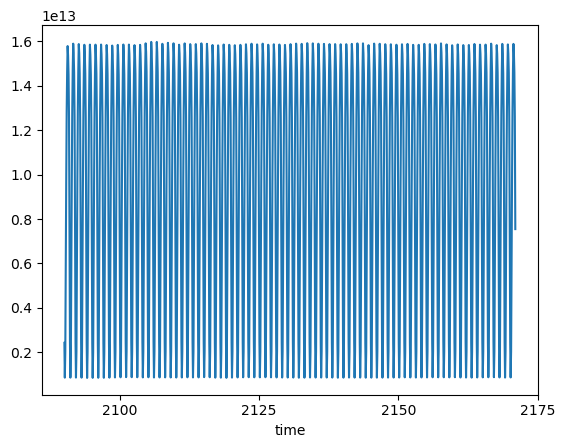

In [11]:
SH_area = area.sel(yt_ocean = slice(-90, -45)).sum(('yt_ocean', 'xt_ocean')).load()
SH_area.plot()

Or, we can look at the seasonal cycle of SH ice concentration, averaged over all 10 years.

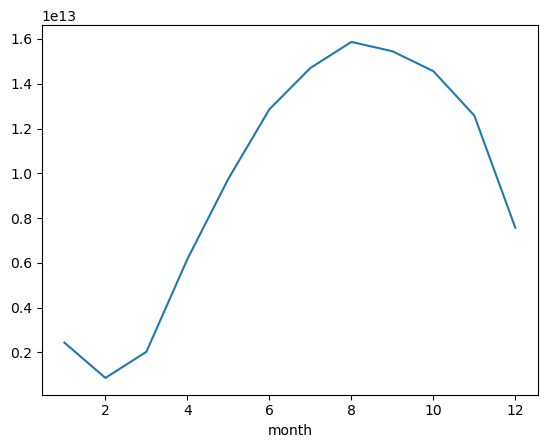

In [8]:
seasonal_cycle = SH_area.groupby('time.month').mean('time')
seasonal_cycle.plot()

We can plot a map of sea ice concentration for a selected month, as follows:

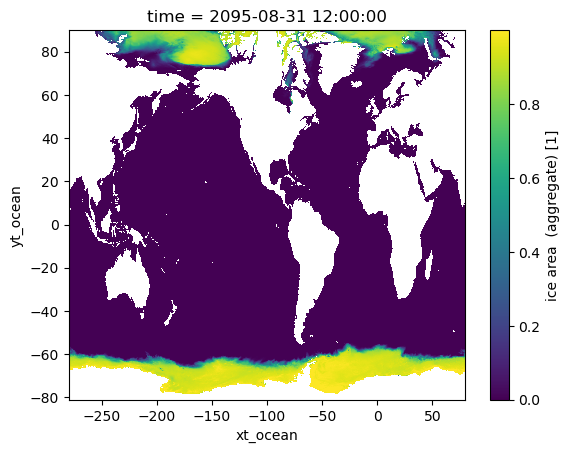

In [9]:
CN_Aug = var.sel(time='2095-08-31')
CN_Aug.plot()

Once we are happy with your plot, we can save the plot to disk using `plt.savefig('filepath/filename')` function at the end of the cell containing the plot we want to save, as shown below. Note that your filename must contain the file (e.g., pdf, jpeg, png, etc.).  
For more information on the options available to save figures refer to [https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html].

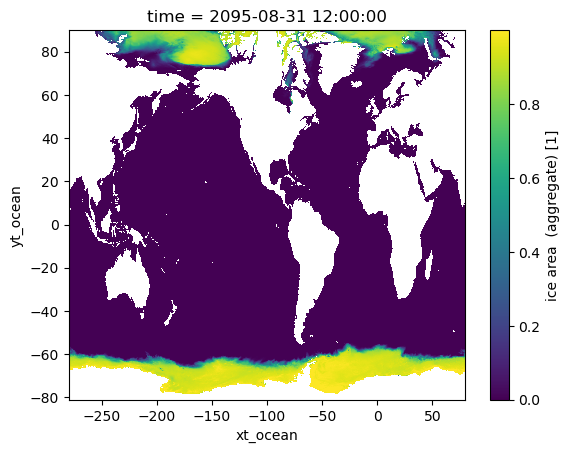

In [10]:
CN_Aug.plot()
plt.savefig('MyFirstPlot.png', dpi = 300)